# Analysing ESG for USA

## Table of Content:
* [Importing Essential Libraries](#libraries)
* [Part I: Data Ingestion, Transformation and Cleaning](#part1)
  - [Import the raw excel file containg ESG Data](#part1-1)
  - [Filter the data for country code of interest](#part1-2)
  - [Adding death rate data](#part1-3)
  - [Analysing NaN & Distinct counts](#part1-4)
  - [Filter Series](#part1-5)
      - [Filter series with all NaNs](#part1-5-1)
      - [Filter Series with <= 20% NaNs and which is not constant](#part1-5-2)
      - [Select candidate target time series for eg. Food Security & Health and Nutrition](#part1-5-3)
  - [Analysing NaN indices](#part1-6)
* [Part II: Creating the related timeseries to the target time series](#part2)
    - [Find the correlation of related with the target time series](#part2-1)
    - [Select the candidates to be used as additional data](#part2-2)
    - [Use `Univariate Forecasting` model to predict the future values for the desired future time horizon for related series](#part2-3)
    
* [Part III: Forecasting for the identified target series](#part3)
  - [Run forecasting service `Multivariate Algorithm` on the target time series, while providing the selected related series as additional features](#part3-1)
  - [Get **Forecasts** for next 5 years, **Confidence Intervals**, **Explainations** and **Error Metric**](#part3-2)
* [Part IV: WhatIfAnalysis / Model Probing](#part4)
  - [Visualize the Features per time stamp](#part4-1)
  - [Model Probing on top 3 important time series](#part4-2)

### Importing Essential Libraries <a class="anchor" id="libraries"></a>

In [1]:
import os
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import re
import requests
import json
import ast
import simplejson
import time
from oci.signer import Signer
from datetime import datetime
import pickle as pkl
from os.path import exists
from prophet import Prophet


# PART I: Data Extraction, Transformation and Cleaning <a class="anchor" id="part1"></a>

#### Select a country of interest

In [2]:
country_code_of_interest = 'USA'

### 1.1. Import the raw excel file containg ESG Data <a class="anchor" id="part1-1"></a>

In [3]:
esg_kaggle_data = openpyxl.load_workbook('ESG Kaggle Data - Combined V2 + Enrich Data Options VD.xlsx')

In [82]:
esg_kaggle_data.sheetnames

['ESG Data',
 'Global Infant Mortality',
 'Death Rate, Crude -per 1000 ppl',
 'World Happiness Data 2015-2019',
 'Avg Age by Country (2018-2020)']

In [83]:
esg_data = pd.DataFrame(esg_kaggle_data['ESG Data'].values)
esg_data.columns=list(esg_data.iloc[0,:])
esg_data = esg_data[1:]
esg_data.head(5)

,Country Name,Country Code,ESG Pillar,ESG Subcategory,Indicator Name,Indicator Code,2000.0,2001.0,2002.0,2003.0,...,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
1,Arab World,ARB,Social,Access to Services,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,73.702495,74.944860,76.258066,77.120464,...,82.368101,82.783289,83.120303,83.533457,83.897596,84.171599,84.510171,NaN,NaN,NaN
2,Caribbean small states,CSS,Social,Access to Services,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,78.335974,79.510343,80.671697,81.645867,...,87.900002,88.639169,89.235672,89.858980,90.477017,91.001057,91.496541,NaN,NaN,NaN
3,Central Europe and the Baltics,CEB,Social,Access to Services,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,87.477397,88.513227,89.440627,90.259447,...,94.049081,94.367808,94.664957,94.884779,95.138227,95.335099,95.485364,NaN,NaN,NaN
4,Early-demographic dividend,EAR,Social,Access to Services,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,31.979647,33.333112,34.475001,35.472825,...,44.167692,45.246802,46.395611,47.493570,48.469181,49.343238,50.277478,NaN,NaN,NaN
5,East Asia & Pacific,EAS,Social,Access to Services,Access to clean fuels and technologies for coo...,EG.CFT.ACCS.ZS,45.159886,46.183423,46.955797,47.894913,...,55.496173,56.548359,57.617948,58.690647,59.542847,60.442414,61.259161,NaN,NaN,NaN


### 1.2. Filter the data for country code of interest <a class="anchor" id="part1-2"></a>

In [84]:
esg_data_selected_country = esg_data[esg_data['Country Code']==country_code_of_interest]
esg_data_selected_country['series_code'] = esg_data_selected_country['Country Code'] +  "_" + esg_data_selected_country['ESG Subcategory'] + "_" + esg_data_selected_country['Indicator Code']
selected_country_df = esg_data_selected_country[list(esg_data_selected_country.columns)[-1:] + list(esg_data_selected_country.columns)[6:-1]]
selected_country_df

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,series_code,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,...,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0
231,USA_Emissions & pollution_EN.ATM.CO2E.PC,20.178751,19.636505,19.613404,19.564105,19.658371,19.591885,19.094067,19.217898,18.461764,...,17.443111,16.915202,16.193429,16.362224,16.416576,15.989866,15.502204,NaN,NaN,NaN
470,USA_Emissions & pollution_EN.ATM.PM25.MC.M3,9.525138,NaN,NaN,NaN,NaN,9.609824,NaN,NaN,NaN,...,9.358636,9.740641,9.003163,8.734777,8.220720,8.063920,7.406464,7.409442,NaN,NaN
709,USA_Energy use & security_EG.ELC.COAL.ZS,52.895152,51.633427,50.657299,51.381168,50.396690,50.457086,49.772878,48.993909,49.104440,...,45.797606,43.345764,38.479856,39.943141,39.650733,34.232734,NaN,NaN,NaN,NaN
948,USA_Energy use & security_EG.IMP.CONS.ZS,26.659420,24.300537,26.604129,27.726181,28.695571,29.659179,27.972123,28.585607,25.264071,...,22.209201,18.554977,15.691729,13.943432,9.214466,7.308743,NaN,NaN,NaN,NaN
1187,USA_Energy use & security_EG.EGY.PRIM.PP.KD,7.335371,7.128217,7.082368,6.904967,6.790206,6.601738,6.369407,6.367571,6.222452,...,6.072479,5.909837,5.692995,5.676036,5.621146,5.408393,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15049,USA_Health & Nutrition_SH.STA.OWAD.ZS,58.600000,59.300000,60.000000,60.700000,61.300000,61.900000,62.500000,63.100000,63.700000,...,64.800000,65.300000,65.800000,66.400000,66.900000,67.400000,67.900000,NaN,NaN,NaN
15288,USA_Health & Nutrition_SN.ITK.DEFC.ZS,NaN,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,...,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.5,NaN
15527,USA_Poverty & Inequality_SI.POV.GINI,40.100000,NaN,NaN,NaN,40.300000,NaN,NaN,40.800000,NaN,...,40.000000,NaN,NaN,40.700000,NaN,NaN,41.100000,NaN,NaN,NaN
15766,USA_Poverty & Inequality_SI.DST.FRST.20,5.500000,NaN,NaN,NaN,5.300000,NaN,NaN,5.200000,NaN,...,5.300000,NaN,NaN,5.300000,NaN,NaN,5.200000,NaN,NaN,NaN


In [85]:
selected_country_df.sort_values(by="series_code", inplace = True)
selected_country_series = selected_country_df.transpose()
selected_country_series.columns = selected_country_series.iloc[0,:]
selected_country_series = selected_country_series[1:]
selected_country_series

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


series_code,USA_Access to Services_EG.CFT.ACCS.ZS,USA_Access to Services_EG.ELC.ACCS.ZS,USA_Access to Services_SH.H2O.SMDW.ZS,USA_Access to Services_SH.STA.SMSS.ZS,USA_Demography_SP.DYN.LE00.IN,USA_Demography_SP.DYN.TFRT.IN,USA_Demography_SP.POP.65UP.TO.ZS,USA_Economic Environment_IC.BUS.EASE.XQ,USA_Economic Environment_IT.NET.USER.ZS,USA_Economic Environment_NY.GDP.MKTP.KD.ZG,...,USA_Natural capital endowment and management_NY.ADJ.DFOR.GN.ZS,USA_Natural capital endowment and management_NY.ADJ.DRES.GN.ZS,USA_Poverty & Inequality_SI.DST.FRST.20,USA_Poverty & Inequality_SI.POV.GINI,USA_Poverty & Inequality_SI.POV.NAHC,USA_Poverty & Inequality_SI.SPR.PCAP.ZG,USA_Stability & Rule of Law_CC.EST,USA_Stability & Rule of Law_PV.EST,USA_Stability & Rule of Law_RL.EST,USA_Stability & Rule of Law_SM.POP.NETM
2000.0,100,100,NaN,88.1928,76.6366,2.056,12.3337,NaN,43.0792,4.12748,...,0,0.624416,5.5,40.1,NaN,NaN,1.65776,1.08451,1.59275,NaN
2001.0,100,100,NaN,88.3073,76.8366,2.0305,12.3139,NaN,49.0808,0.998341,...,0,0.508545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2002.0,100,100,NaN,88.4213,76.9366,2.0205,12.2916,NaN,58.7854,1.7417,...,0,0.325366,NaN,NaN,NaN,NaN,1.92404,0.287509,1.54765,5.33489e+06
2003.0,100,100,NaN,88.5351,77.0366,2.0475,12.2777,NaN,61.6971,2.86121,...,0,0.476881,NaN,NaN,NaN,NaN,1.75544,0.0812887,1.59078,NaN
2004.0,100,100,NaN,88.6491,77.4878,2.0515,12.2826,NaN,64.7583,3.79889,...,0,0.665261,5.3,40.3,NaN,NaN,1.83258,-0.231348,1.43596,NaN
2005.0,100,100,98.9423,88.7622,77.4878,2.057,12.3117,NaN,67.9681,3.51321,...,0,0.728568,NaN,NaN,NaN,NaN,1.54569,-0.0586535,1.53952,NaN
2006.0,100,100,98.9471,88.8755,77.6878,2.108,12.3809,NaN,68.9312,2.85497,...,0,0.608463,NaN,NaN,NaN,NaN,1.35332,0.493943,1.6054,NaN
2007.0,100,100,98.9519,88.9886,77.9878,2.12,12.4719,NaN,75,1.87617,...,0,0.573047,5.2,40.8,NaN,NaN,1.38547,0.37573,1.62786,5.42876e+06
2008.0,100,100,98.9566,89.1015,78.039,2.072,12.5951,NaN,74,-0.13658,...,0,0.962071,NaN,NaN,NaN,NaN,1.45021,0.585224,1.64003,NaN
2009.0,100,100,98.9613,89.2142,78.3902,2.002,12.7626,NaN,71,-2.53676,...,0,0.343418,NaN,NaN,NaN,NaN,1.29435,0.44843,1.59849,NaN


### 1.3. Adding Death Rate Data <a class="anchor" id="part1-3"></a>

In [86]:
death_rate_df = pd.DataFrame(esg_kaggle_data['Death Rate, Crude -per 1000 ppl'].values)
death_rate_df.columns = death_rate_df.loc[0]
death_rate_df = death_rate_df.loc[1:]
death_rate_df = death_rate_df[death_rate_df['Country Code']==country_code_of_interest]
death_rate_df

,Country Name,Country Code,Indicator Name,Indicator Code,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,...,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0,2017.0,2018.0,2019.0,2020.0
252,United States,USA,"Death rate, crude (per 1,000 people)",SP.DYN.CDRT.IN,8.5,8.5,8.5,8.4,8.2,8.3,...,8.073,8.102,8.215,8.237,8.44,8.493,8.638,8.678,8.7,NaN


In [87]:
death_rate_indicator_name = death_rate_df['Country Code'].iloc[0] + "_Death Rate_" + death_rate_df['Indicator Code'].iloc[0] 

In [88]:
selected_country_series[death_rate_indicator_name] = list(death_rate_df.values[0][4:-1]) 
selected_country_series

series_code,USA_Access to Services_EG.CFT.ACCS.ZS,USA_Access to Services_EG.ELC.ACCS.ZS,USA_Access to Services_SH.H2O.SMDW.ZS,USA_Access to Services_SH.STA.SMSS.ZS,USA_Demography_SP.DYN.LE00.IN,USA_Demography_SP.DYN.TFRT.IN,USA_Demography_SP.POP.65UP.TO.ZS,USA_Economic Environment_IC.BUS.EASE.XQ,USA_Economic Environment_IT.NET.USER.ZS,USA_Economic Environment_NY.GDP.MKTP.KD.ZG,...,USA_Natural capital endowment and management_NY.ADJ.DRES.GN.ZS,USA_Poverty & Inequality_SI.DST.FRST.20,USA_Poverty & Inequality_SI.POV.GINI,USA_Poverty & Inequality_SI.POV.NAHC,USA_Poverty & Inequality_SI.SPR.PCAP.ZG,USA_Stability & Rule of Law_CC.EST,USA_Stability & Rule of Law_PV.EST,USA_Stability & Rule of Law_RL.EST,USA_Stability & Rule of Law_SM.POP.NETM,USA_Death Rate_SP.DYN.CDRT.IN
2000.0,100,100,NaN,88.1928,76.6366,2.056,12.3337,NaN,43.0792,4.12748,...,0.624416,5.5,40.1,NaN,NaN,1.65776,1.08451,1.59275,NaN,8.500
2001.0,100,100,NaN,88.3073,76.8366,2.0305,12.3139,NaN,49.0808,0.998341,...,0.508545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.500
2002.0,100,100,NaN,88.4213,76.9366,2.0205,12.2916,NaN,58.7854,1.7417,...,0.325366,NaN,NaN,NaN,NaN,1.92404,0.287509,1.54765,5.33489e+06,8.500
2003.0,100,100,NaN,88.5351,77.0366,2.0475,12.2777,NaN,61.6971,2.86121,...,0.476881,NaN,NaN,NaN,NaN,1.75544,0.0812887,1.59078,NaN,8.400
2004.0,100,100,NaN,88.6491,77.4878,2.0515,12.2826,NaN,64.7583,3.79889,...,0.665261,5.3,40.3,NaN,NaN,1.83258,-0.231348,1.43596,NaN,8.200
2005.0,100,100,98.9423,88.7622,77.4878,2.057,12.3117,NaN,67.9681,3.51321,...,0.728568,NaN,NaN,NaN,NaN,1.54569,-0.0586535,1.53952,NaN,8.300
2006.0,100,100,98.9471,88.8755,77.6878,2.108,12.3809,NaN,68.9312,2.85497,...,0.608463,NaN,NaN,NaN,NaN,1.35332,0.493943,1.6054,NaN,8.100
2007.0,100,100,98.9519,88.9886,77.9878,2.12,12.4719,NaN,75,1.87617,...,0.573047,5.2,40.8,NaN,NaN,1.38547,0.37573,1.62786,5.42876e+06,8.000
2008.0,100,100,98.9566,89.1015,78.039,2.072,12.5951,NaN,74,-0.13658,...,0.962071,NaN,NaN,NaN,NaN,1.45021,0.585224,1.64003,NaN,8.100
2009.0,100,100,98.9613,89.2142,78.3902,2.002,12.7626,NaN,71,-2.53676,...,0.343418,NaN,NaN,NaN,NaN,1.29435,0.44843,1.59849,NaN,7.900


In [89]:
all_series_codes = list(selected_country_series.columns)
all_series_codes

['USA_Access to Services_EG.CFT.ACCS.ZS',
 'USA_Access to Services_EG.ELC.ACCS.ZS',
 'USA_Access to Services_SH.H2O.SMDW.ZS',
 'USA_Access to Services_SH.STA.SMSS.ZS',
 'USA_Demography_SP.DYN.LE00.IN',
 'USA_Demography_SP.DYN.TFRT.IN',
 'USA_Demography_SP.POP.65UP.TO.ZS',
 'USA_Economic Environment_IC.BUS.EASE.XQ',
 'USA_Economic Environment_IT.NET.USER.ZS',
 'USA_Economic Environment_NY.GDP.MKTP.KD.ZG',
 'USA_Education & skills_SE.ADT.LITR.ZS',
 'USA_Education & skills_SE.PRM.ENRR',
 'USA_Education & skills_SE.XPD.TOTL.GB.ZS',
 'USA_Emissions & pollution_EN.ATM.CO2E.PC',
 'USA_Emissions & pollution_EN.ATM.METH.PC',
 'USA_Emissions & pollution_EN.ATM.NOXE.PC',
 'USA_Emissions & pollution_EN.ATM.PM25.MC.M3',
 'USA_Emissions & pollution_EN.CLC.GHGR.MT.CE',
 'USA_Employment_SL.TLF.0714.ZS',
 'USA_Employment_SL.TLF.ACTI.ZS',
 'USA_Employment_SL.UEM.TOTL.ZS',
 'USA_Energy use & security_EG.EGY.PRIM.PP.KD',
 'USA_Energy use & security_EG.ELC.COAL.ZS',
 'USA_Energy use & security_EG.ELC.RNEW.

### 1.4. Analysing NaN & Distinct counts <a class="anchor" id="part1-4"></a>

In [90]:
nan_percentage = []
distinct_count = []
for series in all_series_codes:
    nan_percentage.append(selected_country_series[series].isna().sum()/20)
    distinct_count.append(selected_country_series[series].nunique())

In [91]:
EDA = pd.DataFrame({'series_id':list(all_series_codes),'nan_percent':nan_percentage,'distinct_count':distinct_count })
EDA

,series_id,nan_percent,distinct_count
0,USA_Access to Services_EG.CFT.ACCS.ZS,0.15,1
1,USA_Access to Services_EG.ELC.ACCS.ZS,0.05,1
2,USA_Access to Services_SH.H2O.SMDW.ZS,0.35,13
3,USA_Access to Services_SH.STA.SMSS.ZS,0.10,18
4,USA_Demography_SP.DYN.LE00.IN,0.05,15
...,...,...,...
63,USA_Stability & Rule of Law_CC.EST,0.05,19
64,USA_Stability & Rule of Law_PV.EST,0.05,19
65,USA_Stability & Rule of Law_RL.EST,0.05,19
66,USA_Stability & Rule of Law_SM.POP.NETM,0.80,4


### 1.5. Filter Time Series <a class="anchor" id="part1-5"></a>

#### 1.5.1. Series with all NaNs <a class="anchor" id="part1-5-1"></a>

In [92]:
EDA[EDA['distinct_count']==0].count()

series_id         8
nan_percent       8
distinct_count    8
dtype: int64

In [93]:
EDA[EDA['distinct_count']==0]['series_id']

10                USA_Education & skills_SE.ADT.LITR.ZS
12             USA_Education & skills_SE.XPD.TOTL.GB.ZS
18                        USA_Employment_SL.TLF.0714.ZS
28    USA_Environment/climate risk & resilience_EN.C...
29    USA_Environment/climate risk & resilience_EN.C...
31    USA_Environment/climate risk & resilience_EN.C...
32    USA_Environment/climate risk & resilience_EN.C...
61                 USA_Poverty & Inequality_SI.POV.NAHC
Name: series_id, dtype: object

#### 1.5.2. Series with <= 20% NaNs and which is not constant <a class="anchor" id="part1-5-2"></a>

In [94]:
EDA[(EDA['nan_percent']<=0.2) & (EDA['distinct_count']>1)].count()

series_id         39
nan_percent       39
distinct_count    39
dtype: int64

In [95]:
EDA[(EDA['nan_percent']<=0.2) & (EDA['distinct_count']>1)]['series_id']

3                 USA_Access to Services_SH.STA.SMSS.ZS
4                         USA_Demography_SP.DYN.LE00.IN
5                         USA_Demography_SP.DYN.TFRT.IN
6                      USA_Demography_SP.POP.65UP.TO.ZS
8               USA_Economic Environment_IT.NET.USER.ZS
9            USA_Economic Environment_NY.GDP.MKTP.KD.ZG
11                   USA_Education & skills_SE.PRM.ENRR
13             USA_Emissions & pollution_EN.ATM.CO2E.PC
19                        USA_Employment_SL.TLF.ACTI.ZS
20                        USA_Employment_SL.UEM.TOTL.ZS
21          USA_Energy use & security_EG.EGY.PRIM.PP.KD
22             USA_Energy use & security_EG.ELC.COAL.ZS
23             USA_Energy use & security_EG.ELC.RNEW.ZS
24             USA_Energy use & security_EG.FEC.RNEW.ZS
25             USA_Energy use & security_EG.IMP.CONS.ZS
26          USA_Energy use & security_EG.USE.COMM.FO.ZS
27          USA_Energy use & security_EG.USE.PCAP.KG.OE
33    USA_Environment/climate risk & resilience_

#### 1.5.3. Select candidate target time series for eg. Food Security & Health and Nutrition <a class="anchor" id="part1-5-3"></a>

In [96]:
EDA[(EDA['nan_percent']<=0.2) & (EDA['distinct_count']>1) & (EDA['series_id'].str.contains("Food|Health"))]['series_id']

34         USA_Food Security_AG.LND.AGRI.ZS
35         USA_Food Security_AG.PRD.FOOD.XD
36         USA_Food Security_NV.AGR.TOTL.ZS
44       USA_Health & Nutrition_SH.DYN.MORT
45    USA_Health & Nutrition_SH.MED.BEDS.ZS
46    USA_Health & Nutrition_SH.STA.OWAD.ZS
Name: series_id, dtype: object

In [97]:
EDA[EDA['series_id'].str.contains("Food|Health")]

,series_id,nan_percent,distinct_count
34,USA_Food Security_AG.LND.AGRI.ZS,0.15,16
35,USA_Food Security_AG.PRD.FOOD.XD,0.15,17
36,USA_Food Security_NV.AGR.TOTL.ZS,0.05,19
43,USA_Health & Nutrition_SH.DTH.COMM.ZS,0.80,4
44,USA_Health & Nutrition_SH.DYN.MORT,0.00,18
45,USA_Health & Nutrition_SH.MED.BEDS.ZS,0.10,18
46,USA_Health & Nutrition_SH.STA.OWAD.ZS,0.15,17
47,USA_Health & Nutrition_SN.ITK.DEFC.ZS,0.10,1


In [98]:
filtered_series = selected_country_series[EDA[(EDA['nan_percent']<=0.2) & (EDA['distinct_count']>1)]['series_id']]
filtered_series

series_code,USA_Access to Services_SH.STA.SMSS.ZS,USA_Demography_SP.DYN.LE00.IN,USA_Demography_SP.DYN.TFRT.IN,USA_Demography_SP.POP.65UP.TO.ZS,USA_Economic Environment_IT.NET.USER.ZS,USA_Economic Environment_NY.GDP.MKTP.KD.ZG,USA_Education & skills_SE.PRM.ENRR,USA_Emissions & pollution_EN.ATM.CO2E.PC,USA_Employment_SL.TLF.ACTI.ZS,USA_Employment_SL.UEM.TOTL.ZS,...,USA_Human Rights_VA.EST,USA_Innovation_GB.XPD.RSDV.GD.ZS,USA_Innovation_IP.JRN.ARTC.SC,USA_Innovation_IP.PAT.RESD,USA_Natural capital endowment and management_AG.LND.FRST.ZS,USA_Natural capital endowment and management_NY.ADJ.DRES.GN.ZS,USA_Stability & Rule of Law_CC.EST,USA_Stability & Rule of Law_PV.EST,USA_Stability & Rule of Law_RL.EST,USA_Death Rate_SP.DYN.CDRT.IN
2000.0,88.1928,76.6366,2.056,12.3337,43.0792,4.12748,100.73,20.1788,76.43,3.99,...,1.31017,2.62879,304782,164795,33.1302,0.624416,1.65776,1.08451,1.59275,8.500
2001.0,88.3073,76.8366,2.0305,12.3139,49.0808,0.998341,101.326,19.6365,75.93,4.73,...,NaN,2.6483,305613,177513,33.1568,0.508545,NaN,NaN,NaN,8.500
2002.0,88.4213,76.9366,2.0205,12.2916,58.7854,1.7417,99.8794,19.6134,75.42,5.78,...,1.34457,2.55926,319308,184245,33.1835,0.325366,1.92404,0.287509,1.54765,8.500
2003.0,88.5351,77.0366,2.0475,12.2777,61.6971,2.86121,101.114,19.5641,74.78,5.99,...,1.33823,2.56455,329399,188941,33.2101,0.476881,1.75544,0.0812887,1.59078,8.400
2004.0,88.6491,77.4878,2.0515,12.2826,64.7583,3.79889,101.25,19.6584,74.35,5.53,...,1.32775,2.50243,353853,189536,33.2368,0.665261,1.83258,-0.231348,1.43596,8.200
2005.0,88.7622,77.4878,2.057,12.3117,67.9681,3.51321,101.874,19.5919,74.26,5.08,...,1.29452,2.51697,384573,207867,33.2634,0.728568,1.54569,-0.0586535,1.53952,8.300
2006.0,88.8755,77.6878,2.108,12.3809,68.9312,2.85497,102.201,19.0941,74.37,4.62,...,1.10162,2.55764,385515,221784,33.35,0.608463,1.35332,0.493943,1.6054,8.100
2007.0,88.9886,77.9878,2.12,12.4719,75,1.87617,103.093,19.2179,74.11,4.62,...,1.10981,2.63161,391910,241347,33.4365,0.573047,1.38547,0.37573,1.62786,8.000
2008.0,89.1015,78.039,2.072,12.5951,74,-0.13658,103.235,18.4618,74.04,5.78,...,1.14427,2.76791,393979,231588,33.5761,0.962071,1.45021,0.585224,1.64003,8.100
2009.0,89.2142,78.3902,2.002,12.7626,71,-2.53676,102.212,17.1577,73.3,9.25,...,1.09721,2.8127,399350,224912,33.6628,0.343418,1.29435,0.44843,1.59849,7.900


In [99]:
potential_target_series = list(EDA[(EDA['nan_percent']<=0.2) & (EDA['distinct_count']>1) & (EDA['series_id'].str.contains("Food|Health"))]['series_id'])
potential_target_series

['USA_Food Security_AG.LND.AGRI.ZS',
 'USA_Food Security_AG.PRD.FOOD.XD',
 'USA_Food Security_NV.AGR.TOTL.ZS',
 'USA_Health & Nutrition_SH.DYN.MORT',
 'USA_Health & Nutrition_SH.MED.BEDS.ZS',
 'USA_Health & Nutrition_SH.STA.OWAD.ZS']

In [100]:
potential_additional_series = list(set(filtered_series.columns) - set(potential_target_series))
potential_additional_series.sort()
potential_additional_series

['USA_Access to Services_SH.STA.SMSS.ZS',
 'USA_Death Rate_SP.DYN.CDRT.IN',
 'USA_Demography_SP.DYN.LE00.IN',
 'USA_Demography_SP.DYN.TFRT.IN',
 'USA_Demography_SP.POP.65UP.TO.ZS',
 'USA_Economic Environment_IT.NET.USER.ZS',
 'USA_Economic Environment_NY.GDP.MKTP.KD.ZG',
 'USA_Education & skills_SE.PRM.ENRR',
 'USA_Emissions & pollution_EN.ATM.CO2E.PC',
 'USA_Employment_SL.TLF.ACTI.ZS',
 'USA_Employment_SL.UEM.TOTL.ZS',
 'USA_Energy use & security_EG.EGY.PRIM.PP.KD',
 'USA_Energy use & security_EG.ELC.COAL.ZS',
 'USA_Energy use & security_EG.ELC.RNEW.ZS',
 'USA_Energy use & security_EG.FEC.RNEW.ZS',
 'USA_Energy use & security_EG.IMP.CONS.ZS',
 'USA_Energy use & security_EG.USE.COMM.FO.ZS',
 'USA_Energy use & security_EG.USE.PCAP.KG.OE',
 'USA_Environment/climate risk & resilience_EN.POP.DNST',
 'USA_Gender_SE.ENR.PRSC.FM.ZS',
 'USA_Gender_SG.GEN.PARL.ZS',
 'USA_Gender_SL.TLF.CACT.FM.ZS',
 'USA_Government Effectiveness_GE.EST',
 'USA_Government Effectiveness_RQ.EST',
 'USA_Human Rights

### 1.6. Analysing NaN indices  <a class="anchor" id="part1-6"></a>

In [101]:
nan_indices_target_series = {}
for series in potential_target_series:
    nan_indices_target_series[series] = np.where(filtered_series[series].isna())[0] 
nan_indices_targtet_series_df = pd.DataFrame({'series_id':nan_indices_target_series.keys(), 'nan_indices':nan_indices_target_series.values()})
nan_indices_targtet_series_df

,series_id,nan_indices
0,USA_Food Security_AG.LND.AGRI.ZS,"[17, 18, 19]"
1,USA_Food Security_AG.PRD.FOOD.XD,"[17, 18, 19]"
2,USA_Food Security_NV.AGR.TOTL.ZS,[19]
3,USA_Health & Nutrition_SH.DYN.MORT,[]
4,USA_Health & Nutrition_SH.MED.BEDS.ZS,"[18, 19]"
5,USA_Health & Nutrition_SH.STA.OWAD.ZS,"[17, 18, 19]"


In [102]:
target_series_to_keep = []
acceptable_missing_indices = [[],[19],[18,19],[17,18,19]]
for series in potential_target_series:
    nan_indices = list(np.where(filtered_series[series].isna())[0])
    if nan_indices in acceptable_missing_indices:
        target_series_to_keep.append(series)
        
target_series_to_keep

['USA_Food Security_AG.LND.AGRI.ZS',
 'USA_Food Security_AG.PRD.FOOD.XD',
 'USA_Food Security_NV.AGR.TOTL.ZS',
 'USA_Health & Nutrition_SH.DYN.MORT',
 'USA_Health & Nutrition_SH.MED.BEDS.ZS',
 'USA_Health & Nutrition_SH.STA.OWAD.ZS']

In [103]:
len(target_series_to_keep)

6

In [104]:
nan_indices_additional_series = {}
for series in potential_additional_series:
    nan_indices_additional_series[series] = np.where(filtered_series[series].isna())[0] 
nan_indices_additional_series_df = pd.DataFrame({'series_id':nan_indices_additional_series.keys(), 'nan_indices':nan_indices_additional_series.values()})
nan_indices_additional_series_df

,series_id,nan_indices
0,USA_Access to Services_SH.STA.SMSS.ZS,"[18, 19]"
1,USA_Death Rate_SP.DYN.CDRT.IN,[]
2,USA_Demography_SP.DYN.LE00.IN,[19]
3,USA_Demography_SP.DYN.TFRT.IN,[19]
4,USA_Demography_SP.POP.65UP.TO.ZS,[]
5,USA_Economic Environment_IT.NET.USER.ZS,[]
6,USA_Economic Environment_NY.GDP.MKTP.KD.ZG,[]
7,USA_Education & skills_SE.PRM.ENRR,[19]
8,USA_Emissions & pollution_EN.ATM.CO2E.PC,"[17, 18, 19]"
9,USA_Employment_SL.TLF.ACTI.ZS,[]


In [105]:
additional_series_to_keep = []
acceptable_missing_indices = [[],[19],[18,19],[17,18,19]]
for series in potential_additional_series:
    nan_indices = list(np.where(filtered_series[series].isna())[0])
    if nan_indices in acceptable_missing_indices:
        additional_series_to_keep.append(series)
additional_series_to_keep

['USA_Access to Services_SH.STA.SMSS.ZS',
 'USA_Death Rate_SP.DYN.CDRT.IN',
 'USA_Demography_SP.DYN.LE00.IN',
 'USA_Demography_SP.DYN.TFRT.IN',
 'USA_Demography_SP.POP.65UP.TO.ZS',
 'USA_Economic Environment_IT.NET.USER.ZS',
 'USA_Economic Environment_NY.GDP.MKTP.KD.ZG',
 'USA_Education & skills_SE.PRM.ENRR',
 'USA_Emissions & pollution_EN.ATM.CO2E.PC',
 'USA_Employment_SL.TLF.ACTI.ZS',
 'USA_Employment_SL.UEM.TOTL.ZS',
 'USA_Environment/climate risk & resilience_EN.POP.DNST',
 'USA_Gender_SE.ENR.PRSC.FM.ZS',
 'USA_Gender_SL.TLF.CACT.FM.ZS',
 'USA_Innovation_GB.XPD.RSDV.GD.ZS',
 'USA_Innovation_IP.JRN.ARTC.SC',
 'USA_Innovation_IP.PAT.RESD',
 'USA_Natural capital endowment and management_AG.LND.FRST.ZS',
 'USA_Natural capital endowment and management_NY.ADJ.DRES.GN.ZS']

In [106]:
len(additional_series_to_keep)

19

In [107]:
selected_series = filtered_series[target_series_to_keep + additional_series_to_keep]
selected_series = selected_series.astype(float)
selected_series

series_code,USA_Food Security_AG.LND.AGRI.ZS,USA_Food Security_AG.PRD.FOOD.XD,USA_Food Security_NV.AGR.TOTL.ZS,USA_Health & Nutrition_SH.DYN.MORT,USA_Health & Nutrition_SH.MED.BEDS.ZS,USA_Health & Nutrition_SH.STA.OWAD.ZS,USA_Access to Services_SH.STA.SMSS.ZS,USA_Death Rate_SP.DYN.CDRT.IN,USA_Demography_SP.DYN.LE00.IN,USA_Demography_SP.DYN.TFRT.IN,...,USA_Employment_SL.TLF.ACTI.ZS,USA_Employment_SL.UEM.TOTL.ZS,USA_Environment/climate risk & resilience_EN.POP.DNST,USA_Gender_SE.ENR.PRSC.FM.ZS,USA_Gender_SL.TLF.CACT.FM.ZS,USA_Innovation_GB.XPD.RSDV.GD.ZS,USA_Innovation_IP.JRN.ARTC.SC,USA_Innovation_IP.PAT.RESD,USA_Natural capital endowment and management_AG.LND.FRST.ZS,USA_Natural capital endowment and management_NY.ADJ.DRES.GN.ZS
2000.0,45.230585,95.96,1.150456,8.4,3.49,58.6,88.192771,8.500,76.636585,2.0560,...,76.430000,3.99,30.797301,0.99935,79.541783,2.62879,304781.56,164795.0,33.130174,0.624416
2001.0,45.290070,93.67,1.129326,8.3,3.47,59.3,88.307274,8.500,76.836585,2.0305,...,75.930000,4.73,31.103628,1.00731,79.826224,2.64830,305612.91,177513.0,33.156826,0.508545
2002.0,45.084873,94.09,0.970431,8.2,3.39,60.0,88.421291,8.500,76.936585,2.0205,...,75.419998,5.78,31.393550,1.00125,80.084742,2.55926,319307.62,184245.0,33.183482,0.325366
2003.0,45.178849,95.66,1.115257,8.1,3.33,60.7,88.535126,8.400,77.036585,2.0475,...,74.779999,5.99,31.664535,1.00255,80.654063,2.56455,329398.86,188941.0,33.210134,0.476881
2004.0,44.916459,100.53,1.258660,8.1,3.26,61.3,88.649076,8.200,77.487805,2.0515,...,74.349998,5.53,31.958945,1.00766,80.517863,2.50243,353853.49,189536.0,33.236790,0.665261
2005.0,44.945164,99.30,1.142255,8.0,3.20,61.9,88.762228,8.300,77.487805,2.0570,...,74.260002,5.08,32.254877,1.00387,80.709533,2.51697,384572.94,207867.0,33.263443,0.728568
2006.0,44.664744,100.18,1.000678,7.9,3.18,62.5,88.875495,8.100,77.687805,2.1080,...,74.370003,4.62,32.567400,1.00163,80.700059,2.55764,385515.00,221784.0,33.349952,0.608463
2007.0,45.062344,104.84,1.066822,7.7,3.14,63.1,88.988578,8.000,77.987805,2.1200,...,74.110001,4.62,32.878611,1.00309,80.927907,2.63161,391909.59,241347.0,33.436462,0.573047
2008.0,45.183516,107.59,1.065783,7.6,3.13,63.7,89.101468,8.100,78.039024,2.0720,...,74.040001,5.78,33.243687,0.99985,81.454649,2.76791,393978.95,231588.0,33.576114,0.962071
2009.0,44.817084,109.89,0.968573,7.5,3.08,64.2,89.214165,7.900,78.390244,2.0020,...,73.300003,9.25,33.536399,1.00979,82.188297,2.81270,399350.31,224912.0,33.662760,0.343418


# PART II: Imputing additional series for the years till 2021 <a class="anchor" id="part2"></a>

### 2.1. Find the correlation of related with the target time series <a class="anchor" id="part2-1"></a>

In [108]:
corr_all = selected_series.corr()

In [109]:
corr_all[target_series_to_keep]

series_code,USA_Food Security_AG.LND.AGRI.ZS,USA_Food Security_AG.PRD.FOOD.XD,USA_Food Security_NV.AGR.TOTL.ZS,USA_Health & Nutrition_SH.DYN.MORT,USA_Health & Nutrition_SH.MED.BEDS.ZS,USA_Health & Nutrition_SH.STA.OWAD.ZS
series_code,,,,,,
USA_Food Security_AG.LND.AGRI.ZS,1.000000,-0.793555,-0.111385,0.851125,0.866837,-0.854861
USA_Food Security_AG.PRD.FOOD.XD,-0.793555,1.000000,-0.065359,-0.964548,-0.955808,0.964567
USA_Food Security_NV.AGR.TOTL.ZS,-0.111385,-0.065359,1.000000,0.261688,0.076396,-0.018479
USA_Health & Nutrition_SH.DYN.MORT,0.851125,-0.964548,0.261688,1.000000,0.980048,-0.992151
USA_Health & Nutrition_SH.MED.BEDS.ZS,0.866837,-0.955808,0.076396,0.980048,1.000000,-0.996088
USA_Health & Nutrition_SH.STA.OWAD.ZS,-0.854861,0.964567,-0.018479,-0.992151,-0.996088,1.000000
USA_Access to Services_SH.STA.SMSS.ZS,-0.857166,0.964270,-0.118685,-0.995616,-0.989745,0.998995
USA_Death Rate_SP.DYN.CDRT.IN,0.214408,-0.247676,-0.333212,-0.222200,0.141721,-0.305813
USA_Demography_SP.DYN.LE00.IN,-0.827956,0.910686,-0.067828,-0.923834,-0.953457,0.962896


### 2.3 Decide the threshold for selecting additional series <a class="anchor" id="part2-2"></a>

In [110]:
selection_threshold = 0.7

#### Save the files to be used later

In [111]:
corr_all[target_series_to_keep].to_csv(f"./output_{country_code_of_interest}/correlations_{country_code_of_interest}.csv")
selected_series[target_series_to_keep].to_csv(f"./output_{country_code_of_interest}/target_series_{country_code_of_interest}.csv")
selected_series[additional_series_to_keep].to_csv(f"./output_{country_code_of_interest}/additional_series_{country_code_of_interest}.csv")
selected_series.to_csv(f"./output_{country_code_of_interest}/selected_series_{country_code_of_interest}.csv")

### 2.3. Use Univariate Forecasting model to predict the future values for the desired future time horizon for related series <a class="anchor" id="part2-3"></a>




 

### Setting up Authentication

In [112]:
import oci
location = oci.config.DEFAULT_LOCATION
oci_config = oci.config.from_file(location)

In [113]:
user_tenancy_id = oci_config['tenancy']
user_id = oci_config['user']
user_fingerprint = oci_config['fingerprint']
user_private_key_file_location = oci_config['key_file']

In [114]:
auth = Signer(
    tenancy= user_tenancy_id,
    user= user_id,
    fingerprint = user_fingerprint,
    private_key_file_location = user_private_key_file_location,
    pass_phrase = 'test'  # optional
)
auth

In [115]:
compartmentId = user_tenancy_id

### Creating a project

In [116]:
url = "https://forecasting.aiservice.us-phoenix-1.oci.oraclecloud.com/20220101/projects"

payload = json.dumps({
  "displayName": "Gartner ESG Demo",
  "compartmentId": compartmentId,
  "description": "Forecasting service API Demo",
  "freeformTags": None,
  "definedTags": None,
  "systemTags": None
})
headers = {
  'Content-Type': 'application/json'
}
response = requests.request("POST", url, headers=headers, data=payload, auth=auth)

print(response.text)

{"id":"ocid1.aiforecastproject.oc1.phx.amaaaaaanif7xwialc6ftm7hrvplkmoy7y2f4aqjsijg3rzugkfce6gnmfsa","displayName":"Gartner ESG Demo","compartmentId":"ocid1.tenancy.oc1..aaaaaaaa25c5a2zpfki3wo4ofza5l72aehvwkjbuavpnzqtmr4nigdgzi57a","description":"Forecasting service API Demo","timeCreated":"2022-07-20T16:56:16.922Z","timeUpdated":"2022-07-20T16:56:16.922Z","lifecycleState":"ACTIVE","freeformTags":{},"definedTags":{"Oracle-Tags":{"CreatedBy":"vesselin.diev@oracle.com","CreatedOn":"2022-07-20T16:56:16.707Z"}},"systemTags":{}}


In [117]:
create_project_response = json.loads(response.text)

In [118]:
create_project_response

{'id': 'ocid1.aiforecastproject.oc1.phx.amaaaaaanif7xwialc6ftm7hrvplkmoy7y2f4aqjsijg3rzugkfce6gnmfsa',
 'displayName': 'Gartner ESG Demo',
 'compartmentId': 'ocid1.tenancy.oc1..aaaaaaaa25c5a2zpfki3wo4ofza5l72aehvwkjbuavpnzqtmr4nigdgzi57a',
 'description': 'Forecasting service API Demo',
 'timeCreated': '2022-07-20T16:56:16.922Z',
 'timeUpdated': '2022-07-20T16:56:16.922Z',
 'lifecycleState': 'ACTIVE',
 'freeformTags': {},
 'definedTags': {'Oracle-Tags': {'CreatedBy': 'vesselin.diev@oracle.com',
   'CreatedOn': '2022-07-20T16:56:16.707Z'}},
 'systemTags': {}}

In [119]:
project_id = create_project_response['id']

In [120]:
project_id

'ocid1.aiforecastproject.oc1.phx.amaaaaaanif7xwialc6ftm7hrvplkmoy7y2f4aqjsijg3rzugkfce6gnmfsa'

### Import the selected series

In [121]:
selected_series_df = pd.read_csv(f"./output_{country_code_of_interest}/selected_series_{country_code_of_interest}.csv")

In [122]:
selected_series_df['date'] = pd.date_range(start='2000-01-01', periods=20, freq='D')

In [123]:
selected_series_df.columns

Index(['Unnamed: 0', 'USA_Food Security_AG.LND.AGRI.ZS',
       'USA_Food Security_AG.PRD.FOOD.XD', 'USA_Food Security_NV.AGR.TOTL.ZS',
       'USA_Health & Nutrition_SH.DYN.MORT',
       'USA_Health & Nutrition_SH.MED.BEDS.ZS',
       'USA_Health & Nutrition_SH.STA.OWAD.ZS',
       'USA_Access to Services_SH.STA.SMSS.ZS',
       'USA_Death Rate_SP.DYN.CDRT.IN', 'USA_Demography_SP.DYN.LE00.IN',
       'USA_Demography_SP.DYN.TFRT.IN', 'USA_Demography_SP.POP.65UP.TO.ZS',
       'USA_Economic Environment_IT.NET.USER.ZS',
       'USA_Economic Environment_NY.GDP.MKTP.KD.ZG',
       'USA_Education & skills_SE.PRM.ENRR',
       'USA_Emissions & pollution_EN.ATM.CO2E.PC',
       'USA_Employment_SL.TLF.ACTI.ZS', 'USA_Employment_SL.UEM.TOTL.ZS',
       'USA_Environment/climate risk & resilience_EN.POP.DNST',
       'USA_Gender_SE.ENR.PRSC.FM.ZS', 'USA_Gender_SL.TLF.CACT.FM.ZS',
       'USA_Innovation_GB.XPD.RSDV.GD.ZS', 'USA_Innovation_IP.JRN.ARTC.SC',
       'USA_Innovation_IP.PAT.RESD',
      

In [124]:
def get_explanations(create_forecast_id):
    url = "https://forecasting.aiservice.us-phoenix-1.oci.oraclecloud.com/20220101/forecasts/{}/explanations/".format(create_forecast_id)
    payload={}
    headers = {}
    response = requests.request("GET", url, headers=headers, data=payload, auth=auth)
    get_forecast_explanations = json.loads(response.text)
    return get_forecast_explanations

In [373]:
def get_forecast(prim_load,add_load,add_schema,target_col,additional_series,forecast_horizon,models,project_id,compartmentId,auth):
    data_frequency = "DAY"
    forecast_frequency = "DAY" 
    
    url = "https://forecasting.aiservice.us-phoenix-1.oci.oraclecloud.com/20220101/forecasts"
    if add_load is not None:
        payload = simplejson.dumps({
            "displayName":target_col ,
            "description": "Gartner ESG FC API Demo",
            "compartmentId": compartmentId,
            "projectId": project_id,
           "forecastCreationDetails":{
              "targetVariables":[
                 target_col
              ],
              "modelDetails":{
                 "models":models
              },
              "forecastHorizon":forecast_horizon,
              "confidenceInterval":"90",
              "errorMeasure":"MAPE",
              "forecastTechnique":"ROCV",
              "forecastFrequency":forecast_frequency,
              "isForecastExplanationRequired":True,
              "dataSourceDetails":{
                 "type":"INLINE",
                 "primaryDataSource":{
                    "isDataGrouped":True,
                    "columnData":prim_load,
                    "columnSchema":[
                        {
                            "columnName": "date",
                            "dataType": "DATE"
                        },
                        {
                            "columnName": target_col,
                            "dataType": "DOUBLE"
                        },
                        {
                            "columnName": "id",
                            "dataType": "STRING"
                        }
                    ],
                    "tsColName": "date",
                    "tsColFormat": "yyyy-MM-dd HH:mm:ss",
                    "dataFrequency": data_frequency,
                 },
                  "additionalDataSource":{
                    "isDataGrouped":True,
                    "columnData":add_load,
                    "columnSchema":add_schema,
                    "tsColName": "date",
                    "tsColFormat": "yyyy-MM-dd HH:mm:ss",
                    "dataFrequency": data_frequency,
                 }
              }
           }
        },ignore_nan=True)
    else:
        payload = simplejson.dumps({
            "displayName": "Gartner Demo",
            "description": "Gartner ESG FC API Demo ",
            "compartmentId": compartmentId,
            "projectId": project_id,
           "forecastCreationDetails":{
              "targetVariables":[
                 target_col
              ],
              "modelDetails":{
                 "models":models
              },
              "forecastHorizon":forecast_horizon,
              "confidenceInterval":"90", #"CI_5_95"
              "errorMeasure":"MAPE",
              "forecastTechnique":"ROCV",
              "forecastFrequency":forecast_frequency,
              "isForecastExplanationRequired":True,
              "dataSourceDetails":{
                 "type":"INLINE",
                 "primaryDataSource":{
                    "isDataGrouped":True,
                    "columnData":prim_load,
                    "columnSchema":[
                        {
                            "columnName": "date",
                            "dataType": "DATE"
                        },
                        {
                            "columnName": target_col,
                            "dataType": "DOUBLE"
                        },
                        {
                            "columnName": "id",
                            "dataType": "STRING"
                        }
                    ],
                    "tsColName": "date",
                    "tsColFormat": "yyyy-MM-dd HH:mm:ss",
                    "dataFrequency": data_frequency,
                 }
              }
           }
        },ignore_nan=True)
        
    headers = {
      'Content-Type': 'application/json'
    }

    response = requests.request("POST", url, headers=headers, data=payload, auth=auth)
    # wait for 10 seconds
    time.sleep(10)
    create_forecast_response = json.loads(response.text)
    print(create_forecast_response)
    create_forecast_id = create_forecast_response['id']

    get_url = "https://forecasting.aiservice.us-phoenix-1.oci.oraclecloud.com/20220101/forecasts/{}".format(create_forecast_id)
    request_no = 0
    response = requests.request("GET", get_url, headers=headers, data=payload, auth=auth)
    request_no = request_no + 1
    print("request no: ", request_no)
    get_forecast_response = json.loads(response.text)
    print(get_forecast_response)
    status = get_forecast_response['lifecycleState'] 
    while status == 'CREATING':
        # wait for 60 seconds before requesting again
        time.sleep(60)
        response = requests.request("GET", get_url, headers={}, data={}, auth=auth)
        get_forecast_response = json.loads(response.text)
        status = get_forecast_response['lifecycleState']
        request_no = request_no + 1
        print("request no: ", request_no)
        print("status: ", status)
        if status=='ACTIVE':
            return get_forecast_response 
        elif status=='FAILED':
            print(get_forecast_response)
    

##### Define a dataframe where results will be stored

In [137]:
imputed_series_df = pd.DataFrame({"YEAR":[x for x in range(2000, 2022)]})

In [138]:
imputed_series_df = pd.read_csv(f"./output_{country_code_of_interest}/imputed_series_{country_code_of_interest}.csv")

In [139]:
series_to_forecast = [i for i in selected_series_df.columns[1:-1] if i not in imputed_series_df.columns ]

In [140]:
for target_series in series_to_forecast:
    target_series_df = df[['date'] +[target_series]]
    target_series_df['id'] = target_series
    target_series_df['date'] = pd.to_datetime(target_series_df['date'],format='%y-%m-%d').apply(lambda x: str(x))
    target_series_df.sort_values(by = "date" , inplace = True)
    target_series_df.dropna(inplace = True)
    # create primary load
    date_col = 'date'
    target_col = target_series
    col_order = [date_col,target_col,'id']
    prim_load = target_series_df[col_order].values.transpose().tolist()
    forecast_horizon = 22 - len(target_series_df)
    print("forecasting for series: ", target_series)
    add_load = None
    add_schema = None
    additional_series = None
    models = ["SMA","DMA","ARIMA"]
    forecast_response = get_forecast(prim_load,add_load,add_schema,target_col,additional_series,forecast_horizon,models,project_id,compartmentId,auth)
    forecasts = forecast_response['forecastResult']['forecast'][0]['forecast']
    complete_series = prim_load[1] + forecasts
    imputed_series_df[target_col] = complete_series
    imputed_series_df.to_csv(f"./output_{country_code_of_interest}/imputed_series_{country_code_of_interest}.csv",index=None)

# PART III: Forecasting for the identified target series <a class="anchor" id="part3"></a>

###  3.1.  Run forecasting service Multivariate Algorithm on the target time series, while providing the selected related series as additional features <a class="anchor" id="part3-1"></a>

#### Import the target and imputed series

In [14]:
df_target = pd.read_csv(f"./output_{country_code_of_interest}/target_series_{country_code_of_interest}.csv",index_col=0)
df_additional = pd.read_csv(f"./output_{country_code_of_interest}/imputed_series_{country_code_of_interest}.csv",index_col=0)
df_target['date'] = pd.date_range(start='2000-01-01', periods=20, freq='D')
df_target['date'] = pd.to_datetime(df_target['date'],format='%y-%m-%d').apply(lambda x: str(x))
df_target.sort_values(by = "date" , inplace = True) #new line added

df_additional['date'] = pd.date_range(start='2000-01-01', periods=22, freq='D') 
df_additional['date'] = pd.to_datetime(df_additional['date'],format='%y-%m-%d').apply(lambda x: str(x))
df_additional.sort_values(by = "date" , inplace = True) #new line added

In [15]:
df_corr = pd.read_csv(f"./output_{country_code_of_interest}/correlations_{country_code_of_interest}.csv")

#### Define two dataframes to store the forecasts and the explanations

In [16]:
forecast_df = pd.DataFrame({'YEAR':[],'target_series':[],'additional_series':[],
                          'best_model':[],'rocv_error':[],'rocv_metric':[],
                          'forecasts':[],'lower_bound':[],'upper_bound':[],'forecast_id':[]})

explanations_df = pd.DataFrame(columns = ['targetColumn', 'bestModel', 'bestHyperParameters',
       'hyperparameterSearchMethod', 'bestModelSelectionMetric',
       'globalFeatureImportance', 'localFeatureImportance'] )

### 3.2. Get Forecasts for next 5 years, Confidence Intervals, Explainations and Error Metric <a class="anchor" id="part3-2"></a>

In [17]:
# select the target series to get the forecast, eg: 'USA_Health & Nutrition_SH.STA.OWAD.ZS' 
df_target.columns.to_list()

['USA_Food Security_AG.LND.AGRI.ZS',
 'USA_Food Security_AG.PRD.FOOD.XD',
 'USA_Food Security_NV.AGR.TOTL.ZS',
 'USA_Health & Nutrition_SH.DYN.MORT',
 'USA_Health & Nutrition_SH.MED.BEDS.ZS',
 'USA_Health & Nutrition_SH.STA.OWAD.ZS',
 'date']

In [395]:
# primary data
# select the target series

for target_series in df_target.columns[:-1]:  # omit the date column at last index
    target_series_df = df_target[['date'] + [target_series]]
    target_series_df['id'] = target_series 
    target_series_df.dropna(inplace = True) 
    target_col = target_series
    col_order = ['date',target_col,'id']
    prim_load = target_series_df[col_order].values.transpose().tolist()
    forecast_horizon = 22 - len(target_series_df)
    print(target_series)

    for use_additional in [ 1]:
        if use_additional:
            # additional data
            # get correlations with this target series
            df_corr_target = df_corr[["series_code",target_series]]
            # filter the series having more than 70% correlations 
            df_corr_target_filtered = df_corr_target[(df_corr_target[target_series]>=0.7)|(df_corr_target[target_series]< -0.7)] 
            # create additional series 
            additional_series = [i for i in df_corr_target_filtered['series_code'] if i != target_series]
            # create additional schema
            add_schema = []
            add_schema = add_schema +  [{"columnName": "date","dataType": "DATE"}]  
            for add_series in additional_series: 
                add_schema = add_schema +  [{"columnName":add_series ,"dataType": "DOUBLE"}] 
            add_schema = add_schema + [{"columnName": "id","dataType": "STRING"}]
            add_load = df_additional[['date'] + additional_series]
            add_load['id'] = target_series 
            add_load = add_load[['date'] + additional_series + ['id']].values.transpose().tolist()
        else:
            # run without any additional data
            add_load = None
            additional_series = []
            add_schema = []
        models = ['ARIMA']
            
        #get forecasts
        forecast_response = get_forecast(prim_load,add_load,add_schema,target_col,additional_series,forecast_horizon,models,project_id,compartmentId,auth)
        print(forecast_response)
        best_model = forecast_response['forecastResult']['metrics']['targetColumns'][0]['bestModel']
        if best_model=='PROPHET':
            rocv_error = forecast_response['forecastResult']['metrics']['targetColumns'][0]['errorMeasureValue']
            rocv_metric =forecast_response['forecastResult']['metrics']['targetColumns'][0]['errorMeasureName'] 
            forecasts = forecast_response['forecastResult']['forecast'][0]['forecast']
            forecast_intervals = forecast_response['forecastResult']['forecast'][0]['predictionInterval'] 
            lower_bound = [interval['lower'] for interval in forecast_intervals]
            upper_bound = [interval['upper'] for interval in forecast_intervals]
            forecast_id = forecast_response['id']
            if len(additional_series)==0:
                additional_series = [None]

            df2 = pd.DataFrame({'YEAR':[2021-i for i in range(forecast_horizon-1,-1,-1)],
                        'target_series':[target_series]*forecast_horizon,
                        'additional_series':[additional_series]*forecast_horizon,
                         'best_model':[best_model]*forecast_horizon,
                          'rocv_error':[rocv_error]*forecast_horizon,
                          'rocv_metric':[rocv_metric]*forecast_horizon,
                        'forecasts':forecasts,
                        'lower_bound':lower_bound,
                        'upper_bound':upper_bound,
                        'forecast_id':[forecast_id]*forecast_horizon})
            forecast_df = forecast_df.append(df2, ignore_index = True)
            forecast_df.to_csv(f"./output_{country_code_of_interest}/gartner_forecasts_{country_code_of_interest}.csv")
            if use_additional:
                # Get the explanations
                get_forecast_explanations = get_explanations(forecast_id)
                df_3 = pd.DataFrame(get_forecast_explanations['explanations'])
                explanations_df = explanations_df.append(df_3, ignore_index = True)
                explanations_df.to_csv(f"./output_{country_code_of_interest}/gartner_explanations_{country_code_of_interest}.csv")
                

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

USA_Food Security_AG.LND.AGRI.ZS
{'description': 'Gartner ESG FC API Demo', 'id': 'ocid1.aiforecast.oc1.phx.amaaaaaanif7xwiamsksmw3nullchvznapu7pgjkiblm37cv5wls7seib55q', 'responseType': None, 'compartmentId': 'ocid1.tenancy.oc1..aaaaaaaa25c5a2zpfki3wo4ofza5l72aehvwkjbuavpnzqtmr4nigdgzi57a', 'projectId': 'ocid1.aiforecastproject.oc1.phx.amaaaaaanif7xwiazjmd57pr2rlx5egpnou6uzzxucubn5wgvg6hriebdf6a', 'displayName': 'USA_Food Security_AG.LND.AGRI.ZS', 'createdBy': None, 'timeCreated': '2022-08-02T16:23:40.580Z', 'timeUpdated': '2022-08-02T16:23:40.580Z', 'lifecyleDetails': None, 'lifecycleState': 'CREATING', 'failureMessage': None, 'trainingMessages': None, 'forecastCreationDetails': {'targetVariables': ['USA_Food Security_AG.LND.AGRI.ZS'], 'modelDetails': {'models': ['ARIMA']}, 'dataSourceDetails': {'type': 'INLINE', 'primaryDataSource': {'isDataGrouped': True, 'tsColName': 'date', 'dataFrequency': 'DAY', 'tsColFormat': 'yyyy-MM-dd HH:mm:ss', 'columnSchema': [{'columnName': 'date', 'data

TypeError: 'NoneType' object is not subscriptable

## PART IV: What if Analysis / Model Probing <a class="anchor" id="part4"></a>

### 4.1. Analyze the Features Importances

#### Import the forecasts table, generated in part III

By looking at the best error metric i.e. rocv_error MAPE,
we can see that 
 - with additional the error  = 0.002715
 - without additional = 0.005039
 
therefore, the additional series has helped to improve the forecast

In [4]:
df_forecasts = pd.read_csv(f"./output_{country_code_of_interest}/gartner_forecasts_{country_code_of_interest}.csv", index_col=0) 
df_forecasts

,YEAR,target_series,additional_series,best_model,rocv_error,rocv_metric,forecasts,lower_bound,upper_bound,forecast_id
0,2017.0,USA_Health & Nutrition_SH.STA.OWAD.ZS,[None],ProphetModel,0.005039,MAPE,68.400000,68.340940,68.456100,ocid1.aiforecast.oc1.phx.amaaaaaasxs7gpyakkycb...
1,2018.0,USA_Health & Nutrition_SH.STA.OWAD.ZS,[None],ProphetModel,0.005039,MAPE,68.900000,68.708760,69.070420,ocid1.aiforecast.oc1.phx.amaaaaaasxs7gpyakkycb...
2,2019.0,USA_Health & Nutrition_SH.STA.OWAD.ZS,[None],ProphetModel,0.005039,MAPE,69.400000,69.062780,69.712370,ocid1.aiforecast.oc1.phx.amaaaaaasxs7gpyakkycb...
3,2020.0,USA_Health & Nutrition_SH.STA.OWAD.ZS,[None],ProphetModel,0.005039,MAPE,69.900000,69.356460,70.403550,ocid1.aiforecast.oc1.phx.amaaaaaasxs7gpyakkycb...
4,2021.0,USA_Health & Nutrition_SH.STA.OWAD.ZS,[None],ProphetModel,0.005039,MAPE,70.400000,69.637550,71.111680,ocid1.aiforecast.oc1.phx.amaaaaaasxs7gpyakkycb...
5,2017.0,USA_Health & Nutrition_SH.STA.OWAD.ZS,"['USA_Food Security_AG.LND.AGRI.ZS', 'USA_Food...",ProphetModel,0.002715,MAPE,68.425540,68.420810,68.429660,ocid1.aiforecast.oc1.phx.amaaaaaasxs7gpyabhrjm...
6,2018.0,USA_Health & Nutrition_SH.STA.OWAD.ZS,"['USA_Food Security_AG.LND.AGRI.ZS', 'USA_Food...",ProphetModel,0.002715,MAPE,68.907500,68.892430,68.921290,ocid1.aiforecast.oc1.phx.amaaaaaasxs7gpyabhrjm...
7,2019.0,USA_Health & Nutrition_SH.STA.OWAD.ZS,"['USA_Food Security_AG.LND.AGRI.ZS', 'USA_Food...",ProphetModel,0.002715,MAPE,69.358960,69.331070,69.384910,ocid1.aiforecast.oc1.phx.amaaaaaasxs7gpyabhrjm...
8,2020.0,USA_Health & Nutrition_SH.STA.OWAD.ZS,"['USA_Food Security_AG.LND.AGRI.ZS', 'USA_Food...",ProphetModel,0.002715,MAPE,69.847630,69.805170,69.887314,ocid1.aiforecast.oc1.phx.amaaaaaasxs7gpyabhrjm...
9,2021.0,USA_Health & Nutrition_SH.STA.OWAD.ZS,"['USA_Food Security_AG.LND.AGRI.ZS', 'USA_Food...",ProphetModel,0.002715,MAPE,70.321815,70.264275,70.376175,ocid1.aiforecast.oc1.phx.amaaaaaasxs7gpyabhrjm...


#### Select the desired target series for what if analysis:
A desired series would be the one for which there is improvement in the rocv_error when using additional series as compared to not using any additional series

**NOTE:** Select the target series from the above dataframe which looks interesting for getting good insights

In [5]:
selected_target_series = "USA_Health & Nutrition_SH.STA.OWAD.ZS" 

#### Import the explanations table

In [6]:
df_explanations = pd.read_csv(f"./output_{country_code_of_interest}/gartner_explanations_{country_code_of_interest}.csv", index_col=0) 
df_explanations

,targetColumn,bestModel,bestHyperParameters,hyperparameterSearchMethod,bestModelSelectionMetric,globalFeatureImportance,localFeatureImportance
0,USA_Health & Nutrition_SH.STA.OWAD.ZS,PROPHET,"{'changepoint_range': '0.8', 'seasonality_mode...",OPTUNA,MAPE,{'influencingFeatures': {'USA_Environment/clim...,"{'forecastHorizon': 5, 'influencingFeatures': ..."


#### Filter the row for the selected series to get Hyperparameters and Global and Local Feature Importances

In [7]:
# Util get the indicator meanings
def get_indicator_name(indicator_code):
    metadata = pd.read_csv('esg_metadata.csv')
    metadata = metadata[['Indicator Name', 'Indicator Code']].drop_duplicates()
    metadata = metadata.append({"Indicator Name": "Death rate, crude (per 1,000 people)", "Indicator Code": "SP.DYN.CDRT.IN"}, ignore_index=True)
    return metadata[metadata['Indicator Code']==indicator_code]['Indicator Name'].values[0]

In [8]:
df_explanations_selected_series = df_explanations[df_explanations['targetColumn']==selected_target_series].iloc[0] 

In [9]:
hparams = eval(df_explanations_selected_series['bestHyperParameters'])
globalFeatureImportance = eval(df_explanations_selected_series["globalFeatureImportance"])
localFeatureImportance = eval(df_explanations_selected_series["localFeatureImportance"])

#### Global Feature Importance

In [10]:
df_global_feature_importance = pd.DataFrame(globalFeatureImportance['influencingFeatures']).T.sort_values(['normalizedScore'],ascending=False).reset_index().rename(columns = {'index':'additional_series'})
df_global_feature_importance['indicator_name'] = df_global_feature_importance['additional_series'].apply(lambda x: get_indicator_name(x.split('_')[-1]) if x.startswith(country_code_of_interest)  else x)
df_global_feature_importance[['indicator_name', 'additional_series', 'normalizedScore', 'rawScore']]

,indicator_name,additional_series,normalizedScore,rawScore
0,trend,trend,0.598083,2.384844
1,People using safely managed sanitation service...,USA_Access to Services_SH.STA.SMSS.ZS,0.078463,0.312868
2,Population ages 65 and above (% of total popul...,USA_Demography_SP.POP.65UP.TO.ZS,0.065271,0.260266
3,"Mortality rate, under-5 (per 1,000 live births)",USA_Health & Nutrition_SH.DYN.MORT,0.050390,0.200930
4,Population density (people per sq. km of land ...,USA_Environment/climate risk & resilience_EN.P...,0.038950,0.155314
5,"Life expectancy at birth, total (years)",USA_Demography_SP.DYN.LE00.IN,0.030231,0.120543
6,AgeFeature,AgeFeature,0.026015,0.103734
7,"Labor force participation rate, total (% of to...",USA_Employment_SL.TLF.ACTI.ZS,0.021602,0.086136
8,Scientific and technical journal articles,USA_Innovation_IP.JRN.ARTC.SC,0.021303,0.084946
9,Forest area (% of land area),USA_Natural capital endowment and management_A...,0.020353,0.081156


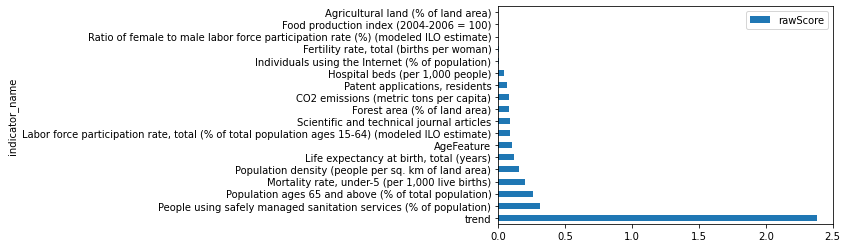

In [11]:
df_global_feature_importance[['indicator_name', 'rawScore']].plot.barh(x='indicator_name', y='rawScore');

#### Local Importance

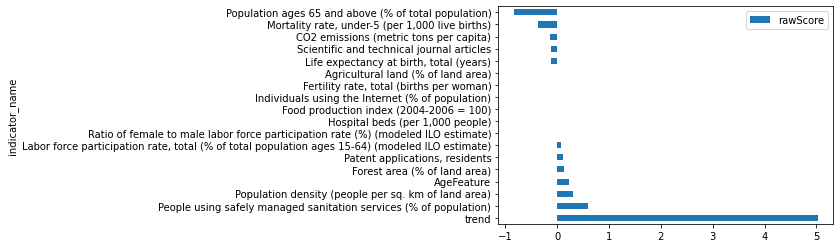

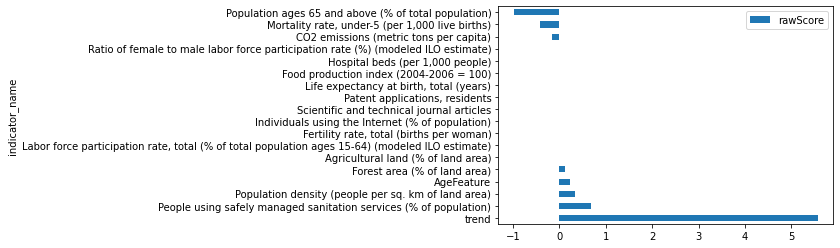

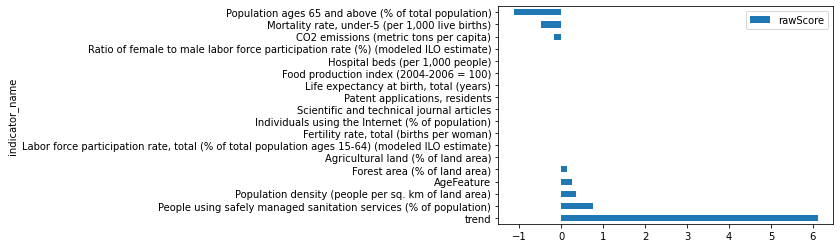

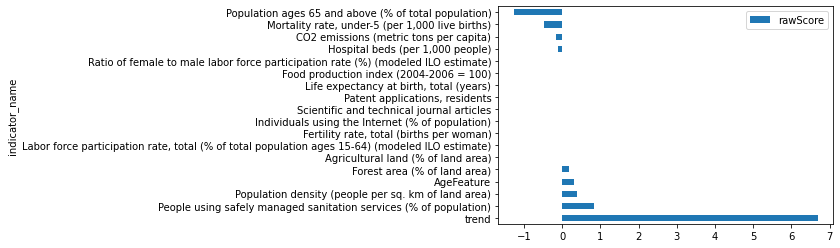

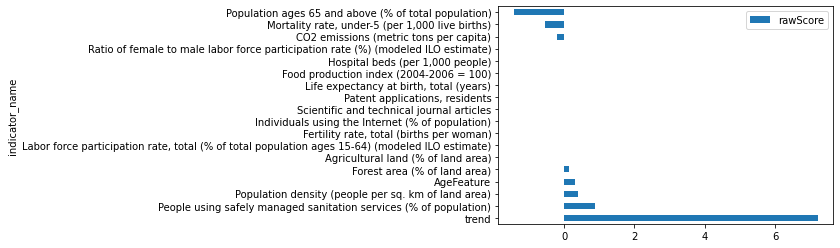

In [12]:
for local_importance_per_timestamp in localFeatureImportance['influencingFeatures']:
    df_local_feature_importance = pd.DataFrame(local_importance_per_timestamp).T.sort_values(['normalizedScore'],ascending=False).reset_index().rename(columns = {'index':'additional_series'})
#     df_local_feature_importance['rawScore'] = df_local_feature_importance['rawScore'].apply(lambda x: abs(x))
    df_local_feature_importance['indicator_name'] = df_local_feature_importance['additional_series'].apply(lambda x: get_indicator_name(x.split('_')[-1]) if x.startswith(country_code_of_interest)  else x)

    df_local_feature_importance[['indicator_name', 'rawScore']].plot.barh(x='indicator_name', y='rawScore');

### 4.2. Model Probing based on additional time series 

#### Import the target series and imputed series

In [19]:
primary_df = df_target[['date',selected_target_series]]
primary_df.loc[:,'id'] = selected_target_series

additional_for_target_series = [i for i in globalFeatureImportance['influencingFeatures'].keys() if i.startswith(country_code_of_interest)]
additional_series_df = df_additional[['date'] + additional_for_target_series ] 
additional_series_df.loc[:,'id'] = selected_target_series 

df = primary_df.merge(additional_series_df, on=['date', 'id'], how='right')
df = df.rename(columns={"date": "ds", selected_target_series: "y"})

df_train, df_test = df.iloc[:17, :], df.iloc[17:,:]
print(df_train.shape, df_test.shape)

(17, 19) (5, 19)


/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [397]:
## If Prophet function call doesn't work below, run this cell and the two following cells & restart kernel to fix it:
#pip uninstall -y pystan 

Found existing installation: pystan 2.19.1.1
Uninstalling pystan-2.19.1.1:
  Successfully uninstalled pystan-2.19.1.1
Note: you may need to restart the kernel to use updated packages.


In [398]:
#pip install pystan==2.18

  Using cached pystan-2.18.0.0-cp36-cp36m-manylinux1_x86_64.whl (50.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
prophet 1.0.1 requires pystan~=2.19.1.1, but you have pystan 2.18.0.0 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [399]:
#pip install prophet

  Using cached pystan-2.19.1.1-cp36-cp36m-manylinux1_x86_64.whl (67.3 MB)
  Attempting uninstall: pystan
    Found existing installation: pystan 2.18.0.0
    Uninstalling pystan-2.18.0.0:
      Successfully uninstalled pystan-2.18.0.0
Note: you may need to restart the kernel to use updated packages.


In [20]:
model_file = f"./output_{country_code_of_interest}/Prophet.pkl"
file_exists = exists(model_file)
if file_exists:
    with open(model_file, "rb") as fp:
        model = pkl.load(fp)
else:
    model = Prophet(
                growth="linear",
                changepoints=None,
                n_changepoints=25,
                changepoint_range=float(hparams['changepoint_range']),
                yearly_seasonality=False,
                weekly_seasonality=False,
                daily_seasonality=False,
                holidays=None,
                seasonality_mode=hparams['seasonality_mode'],
                seasonality_prior_scale=float(hparams['seasonality_prior_scale']),
                holidays_prior_scale=float(hparams['holidays_prior_scale']),
                changepoint_prior_scale=float(hparams['changepoint_prior_scale']),
                mcmc_samples=0,
                interval_width=0.95,
                uncertainty_samples=1000,
            )

    for col_name in [col for col in additional_series_df.columns if col not in ['date', 'id']]:
        model.add_regressor(col_name)

    model.fit(df=df_train)
    
    with open(model_file, "wb") as fp:
        pkl.dump(model,fp)

INFO:prophet:n_changepoints greater than number of observations. Using 12.


In [21]:
df_future = df_test.copy()
df_forecast = model.predict(df_future)

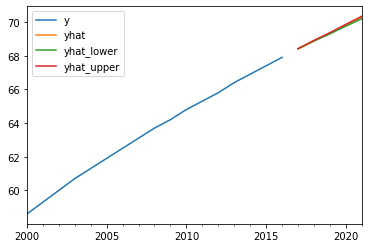

In [22]:
df_plot = pd.concat([df_train, df_forecast])
df_plot.index = pd.to_datetime(list(map(lambda x: f"{x}-01-01", list(range(2000, 2022)))))
df_plot[['y', 'yhat', 'yhat_lower', 'yhat_upper']].plot();

#### Probe features based on the importance

Change feature slider to see the difference in the values of future time stamps.

**NOTE:** The feature sliders are sorted based on the global feature importance

In [23]:
sorted_features = [feature for feature in df_global_feature_importance['additional_series'].values if feature not in ['id', 'ds', 'y', 'trend', 'AgeFeature']]


In [29]:
sorted_features

['USA_Access to Services_SH.STA.SMSS.ZS',
 'USA_Demography_SP.POP.65UP.TO.ZS',
 'USA_Health & Nutrition_SH.DYN.MORT',
 'USA_Environment/climate risk & resilience_EN.POP.DNST',
 'USA_Demography_SP.DYN.LE00.IN',
 'USA_Employment_SL.TLF.ACTI.ZS',
 'USA_Innovation_IP.JRN.ARTC.SC',
 'USA_Natural capital endowment and management_AG.LND.FRST.ZS',
 'USA_Emissions & pollution_EN.ATM.CO2E.PC',
 'USA_Innovation_IP.PAT.RESD',
 'USA_Health & Nutrition_SH.MED.BEDS.ZS',
 'USA_Economic Environment_IT.NET.USER.ZS',
 'USA_Demography_SP.DYN.TFRT.IN',
 'USA_Gender_SL.TLF.CACT.FM.ZS',
 'USA_Food Security_AG.PRD.FOOD.XD',
 'USA_Food Security_AG.LND.AGRI.ZS']

In [31]:
target_series_name

'Prevalence of overweight (% of adults)'

In [32]:
selected_target_series

'USA_Health & Nutrition_SH.STA.OWAD.ZS'

In [30]:
[get_indicator_name(feature.split('_')[-1]) for feature in sorted_features]

['People using safely managed sanitation services (% of population)',
 'Population ages 65 and above (% of total population)',
 'Mortality rate, under-5 (per 1,000 live births)',
 'Population density (people per sq. km of land area)',
 'Life expectancy at birth, total (years)',
 'Labor force participation rate, total (% of total population ages 15-64) (modeled ILO estimate)',
 'Scientific and technical journal articles',
 'Forest area (% of land area)',
 'CO2 emissions (metric tons per capita)',
 'Patent applications, residents',
 'Hospital beds (per 1,000 people)',
 'Individuals using the Internet (% of population)',
 'Fertility rate, total (births per woman)',
 'Ratio of female to male labor force participation rate (%) (modeled ILO estimate)',
 'Food production index (2004-2006 = 100)',
 'Agricultural land (% of land area)']

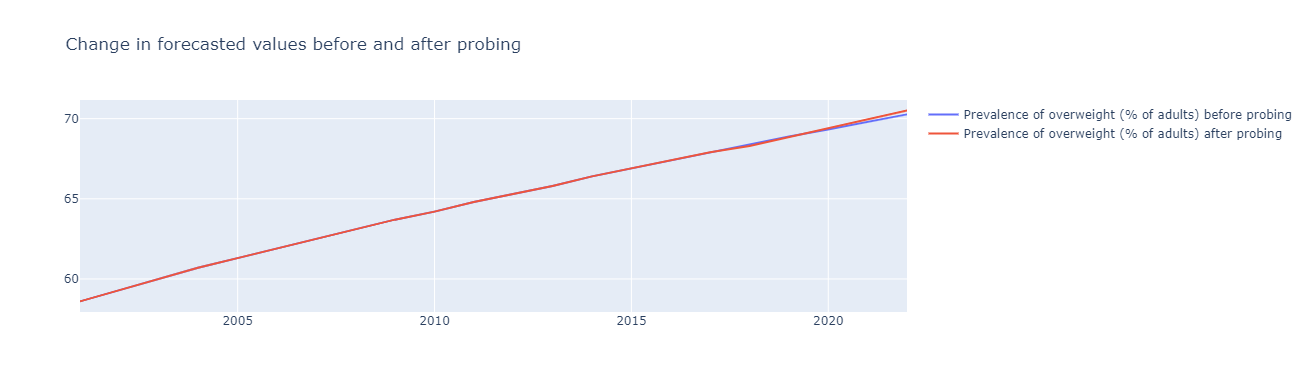

In [28]:
from ipywidgets import IntSlider, FloatSlider, HBox, Label
from ipywidgets import interactive
from IPython.display import display
import plotly.graph_objects as go

target_series_name = get_indicator_name(selected_target_series.split('_')[-1])

sliders = {}
style = {'description_width': 'initial'}
for feature in sorted_features:
    max_value = df_future[feature].max()
    s = FloatSlider(
            value=max_value,
            min=0,
            max=max_value * 10,
            step=0.1,
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout=True,
            readout_format='.1f',
            description=get_indicator_name(feature.split('_')[-1])
    )
    
    sliders[feature] = s

    
df_fitted = df_train.copy()
df_fitted = model.predict(df_fitted)


df_future = df_test.copy()
predictions_original = pd.concat([df_fitted , model.predict(df_future)])
predictions_original['ds'] = pd.date_range('2000-01-01', periods=22,  freq='Y')

def f(**kwargs):
    
    df_future = df_test.copy()
    
    for key, value in kwargs.items():
        df_future[key] = value
    
    predictions_probed = pd.concat([df_fitted , model.predict(df_future)])
    predictions_probed['ds'] = pd.date_range('2000-01-01', periods=22,  freq='Y')

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(
            x=predictions_original["ds"].to_list(),
            y=predictions_original["yhat"].to_list(),
            name=f"{target_series_name} before probing" 
        )
    )

    fig.add_trace(
        go.Scatter(
            x=predictions_probed["ds"].to_list(),
            y=predictions_probed["yhat"].to_list(),
            name=f"{target_series_name} after probing" 
        )
    )
    fig.update_layout(
        title="Change in forecasted values before and after probing",
    )

    fig.show()

w = interactive(f, **sliders);
display(w)